In [1]:
import jax
import jax.numpy as jnp

import optax
import flax
from flax import linen as nn

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from typing import NamedTuple
from dataclasses import dataclass
from typing import Dict, List, Optional
import pandas as pd

import time

from dataclasses import dataclass
import pandas as pd

# Set JAX to use 64-bit precision
jax.config.update("jax_enable_x64", True)

# Setup

In [2]:
# Configuration
tolerance = 1e-10
time_steps = 1000

# Configuration: Set to True for full experiment, False for demo
RUN_FULL_EXPERIMENT = True

In [3]:
class SGDState(NamedTuple):
    step: jnp.ndarray
    momentum: jnp.ndarray  # Momentum buffer
    metric_ema: jnp.ndarray  # EMA of metric scale
    rms_ema: Optional[jnp.ndarray] = None  # EMA of RMS for custom_sgd_rms

In [4]:
def custom_sgd(learning_rate=0.1, momentum=0.9, xi=0.1, beta=0.1, weight_decay=0.0):
    """Optimized custom SGD with momentum and metric modification.
    """
    
    # Pre-compute constants
    neg_lr = -learning_rate
    one_minus_beta = 1 - beta
    one_minus_momentum = 1 - momentum

    def init(params):
        """Initialise optimiser state."""
        return SGDState(
            step=jnp.zeros([], dtype=jnp.int32),
            momentum=jax.tree.map(jnp.zeros_like, params),
            metric_ema=jnp.zeros([]),
            rms_ema=None
        )
    
    @jax.jit
    def update(grads, state, params=None):
        """Update parameters using SGD with momentum and metric modification."""
        step = state.step + 1
        
        # Use optax's optimised norm computation
        grad_norm_sq = optax.tree.norm(grads, ord=2, squared=True)
        trace = xi * grad_norm_sq
        
        # Update EMA of metric scale
        new_metric_ema = beta * state.metric_ema + one_minus_beta * trace
        
        # Bias correction and metric scale computation
        metric_corrected = new_metric_ema / (1 - beta ** step)
        metric_scale = 1 / (1 + jnp.abs(metric_corrected))
        
        
        # Combined momentum update and gradient scaling
        new_momentum = jax.tree.map(
            lambda m, g: momentum * m + one_minus_momentum*g, 
            state.momentum, 
            grads
        )
        
        # Apply learning rate and weight decay (optax expects negative updates)
        updates = jax.tree.map(lambda m, p: neg_lr * metric_scale * m /(1 - momentum ** step) - learning_rate * weight_decay * p, new_momentum, params)

        new_state = SGDState(step=step, momentum=new_momentum, metric_ema=new_metric_ema, rms_ema=None)
        
        return updates, new_state
    
    return optax.GradientTransformation(init, update)

def custom_sgd_log(learning_rate=0.1, momentum=0.9, xi=0.1, beta=0.1, weight_decay=0.0):
    """Optimised custom SGD with loss-based metric modification."""
    
    # Pre-compute constants
    neg_lr = -learning_rate
    one_minus_beta = 1 - beta
    one_minus_momentum = 1 - momentum

    def init(params):
        """Initialise optimiser state."""
        return SGDState(
            step=jnp.zeros([], dtype=jnp.int32),
            momentum=jax.tree.map(jnp.zeros_like, params),
            metric_ema=jnp.zeros([]),
            rms_ema=None
        )
    
    @jax.jit
    def update(grads, state, loss, params=None):
        """Update parameters using SGD with momentum and metric modification."""
        step = state.step + 1

        # Use optax's optimised norm computation
        grad_norm_sq = optax.tree.norm(grads, ord=2, squared=True)
        trace = xi * grad_norm_sq
        
        # Update EMA of metric scale
        new_metric_ema = beta * state.metric_ema + one_minus_beta * trace
        
        # Bias correction and loss-based metric scale computation
        metric_corrected = new_metric_ema / (1 - beta ** step)
        metric_scale = loss / (jnp.square(loss) + metric_corrected)
        
        # Combined momentum update and gradient scaling
        new_momentum = jax.tree.map(
            lambda m, g: momentum * m + one_minus_momentum * g, 
            state.momentum, 
            grads
        )
        
        # Apply learning rate and weight decay (optax expects negative updates)
        updates = jax.tree.map(lambda m, p: neg_lr * metric_scale * m / (1 - momentum ** step) - learning_rate * weight_decay * p, new_momentum, params)

        new_state = SGDState(step=step, momentum=new_momentum, metric_ema=new_metric_ema, rms_ema=None)
        
        return updates, new_state
    
    return optax.GradientTransformation(init, update)

def custom_sgd_rms(learning_rate=0.1, momentum=0.9, xi=0.1, beta=0.1, beta_rms=0.99, weight_decay=0.0, eps=1e-8):
    """custom SGD with momentum and metric modification. Gradients are scaled by RMS."""
    
    # Pre-compute constants
    neg_lr = -learning_rate
    one_minus_beta = 1 - beta
    one_minus_beta_rms = 1 - beta_rms
    one_minus_momentum = 1 - momentum
    
    def init(params):
        """Initialise optimiser state."""
        return SGDState(
            step=jnp.zeros([], dtype=jnp.int32),
            momentum=jax.tree.map(jnp.zeros_like, params),
            metric_ema=jnp.zeros([]),
            rms_ema=jax.tree.map(jnp.zeros_like, params)
        )
    
    @jax.jit
    def update(grads, state, params=None):
        """Update parameters using SGD with momentum and metric modification."""
        step = state.step + 1

        # Update EMA of RMS (Root Mean Square) - per parameter
        new_rms_ema = jax.tree.map(
            lambda r, g: beta_rms * r + one_minus_beta_rms * (g ** 2),
            state.rms_ema, grads
        )

        # Bias correction for RMS
        rms_corrected = jax.tree.map(
            lambda r: r / (1 - beta_rms ** step),
            new_rms_ema
        )

        # Calculate gradient norm
        grad_norm_sq = jax.tree_util.tree_reduce(
        lambda acc, g_r_pair: acc + jnp.sum(g_r_pair),
        jax.tree.map(lambda g, r: g ** 2 / (jnp.sqrt(r) + eps), grads, rms_corrected),
        initializer=0.0)
        trace = xi * grad_norm_sq
        
        # Update EMA of metric scale
        new_metric_ema = beta * state.metric_ema + one_minus_beta * trace

        # Bias correction and metric scale computation
        metric_corrected = new_metric_ema / (1 - beta ** step)
        metric_scale = 1 / (1 + jnp.abs(metric_corrected))

        # Combined momentum update and gradient scaling with RMS normalisation
        new_momentum = jax.tree.map(
            lambda m, g: momentum * m + one_minus_momentum * g, 
            state.momentum, 
            grads
        )
        
        # Apply learning rate and weight decay (optax expects negative updates)
        updates = jax.tree.map(lambda m, p, r: neg_lr * metric_scale * m / ((1 - momentum ** step)*(jnp.sqrt(r) + eps))
                               - learning_rate * weight_decay * p, new_momentum, params, rms_corrected)

        new_state = SGDState(step=step, momentum=new_momentum, metric_ema=new_metric_ema, rms_ema=new_rms_ema)
        
        return updates, new_state
    
    return optax.GradientTransformation(init, update)

# Test Functions

In [5]:
# Himmelblau function
@jax.jit
def himmelblau_function(params):
    x, y = params
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

# Ackley function
@jax.jit
def ackley_function(params):
    x, y = params
    a, b, c = 20.0, 0.2, 2 * jnp.pi
    term1 = -a * jnp.exp(-b * jnp.sqrt(0.5 * (x**2 + y**2)))
    term2 = -jnp.exp(0.5 * (jnp.cos(c * x) + jnp.cos(c * y)))
    return term1 + term2 + a + jnp.e

# Rastrigin function
@jax.jit
def rastrigin_function(params):
    x, y = params
    A = 10.0
    return A * 2 + (x**2 - A * jnp.cos(2 * jnp.pi * x)) + (y**2 - A * jnp.cos(2 * jnp.pi * y))

# Define the Beale function
@jax.jit
def beale_function(params):
    x, y = params
    term1 = (1.5 - x + x * y)**2
    term2 = (2.25 - x + x * y**2)**2
    term3 = (2.625 - x + x * y**3)**2
    return term1 + term2 + term3


# Define the Rosenbrock function with a=1, b=100
@jax.jit
def rosenbrock_function(params):
    x, y = params
    a = 1.0
    b = 100.0
    return (a - x)**2 + b * (y - x**2)**2

# Gradients
himmelblau_gradient = jax.jit(jax.grad(himmelblau_function))
ackley_gradient = jax.jit(jax.grad(ackley_function))
rastrigin_gradient = jax.jit(jax.grad(rastrigin_function))
beale_gradient = jax.jit(jax.grad(beale_function))
rosenbrock_gradient = jax.jit(jax.grad(rosenbrock_function))

# Test function registry
test_functions = {
    'beale': {
        'func': beale_function,
        'grad': beale_gradient,
        'global_min': jnp.array([3.0, 0.5]),
        'initial': jnp.array([0.0, 0.0]),
        'xlim': (-1, 4),
        'ylim': (-1, 1),
        'tolerance': 1e-7
    },
    'rosenbrock': {
        'func': rosenbrock_function,
        'grad': rosenbrock_gradient,
        'global_min': jnp.array([1.0, 1.0]),
        'initial': jnp.array([0.0, 0.0]),
        'xlim': (-0.5, 1.5),
        'ylim': (-0.5, 2.0),
        'tolerance': 1e-7
    },
    'himmelblau': {
        'func': himmelblau_function,
        'grad': himmelblau_gradient,
        'global_min': jnp.array([3.0, 2.0]),  # One of four global minima
        'initial': jnp.array([0.0, 0.0]),
        'xlim': (-5, 5),
        'ylim': (-5, 5),
        'tolerance': 1e-6
    },
    'ackley': {
        'func': ackley_function,
        'grad': ackley_gradient,
        'global_min': jnp.array([0.0, 0.0]),
        'initial': jnp.array([2.0, 2.0]),
        'xlim': (-5, 5),
        'ylim': (-5, 5),
        'tolerance': 1e-6
    },
    'rastrigin': {
        'func': rastrigin_function,
        'grad': rastrigin_gradient,
        'global_min': jnp.array([0.0, 0.0]),
        'initial': jnp.array([2.0, 2.0]),
        'xlim': (-5, 5),
        'ylim': (-5, 5),
        'tolerance': 1e-6
    }
}

print("Added test functions:")
for name, info in test_functions.items():
    print(f"  {name}: global minimum = {info['global_min']}")

Added test functions:
  beale: global minimum = [3.  0.5]
  rosenbrock: global minimum = [1. 1.]
  himmelblau: global minimum = [3. 2.]
  ackley: global minimum = [0. 0.]
  rastrigin: global minimum = [0. 0.]


# Optimisation Framework

In [6]:
@dataclass
class OptimisationResult:
    """Store results from optimisation run"""
    optimiser_name: str
    function_name: str
    converged: bool
    iterations: int
    final_value: float
    final_params: jnp.ndarray
    path: jnp.ndarray
    convergence_history: List[float]
    runtime_seconds: float
    config: Dict

def run_optimiser_on_function(optimiser_name: str, optimiser, 
                             function_info: Dict, config: Dict = None, 
                             max_iterations: int = 1000) -> OptimisationResult:
    """Run a single optimiser on a single function with timing and convergence tracking"""
    
    func = function_info['func']
    grad_func = function_info['grad']
    initial_params = function_info['initial']
    tolerance = function_info['tolerance']
    
    if config is None:
        config = {}
    
    # Initialise
    opt_state = optimiser.init(initial_params)
    params = initial_params.copy()
    path = [params.copy()]
    convergence_history = [float(func(params))]
    
    converged = False
    iterations = 0
    runtime = 0.0
    
    for i in range(max_iterations):
        # Start timing after first iteration to exclude JIT compilation
        if i > 0:
            start_time = time.time()
        
        # Compute gradients
        grads = grad_func(params)
        
        # Update parameters - handle different optimizer signatures
        if optimiser_name == 'custom_sgd_log':
            # Old version expects loss as a separate parameter (third parameter)
            current_loss = func(params)
            updates, opt_state = optimiser.update(grads, opt_state, current_loss, params)
        else:
            # All other optimizers follow standard optax signature
            updates, opt_state = optimiser.update(grads, opt_state, params)
        
        params = optax.apply_updates(params, updates)
        
        # End timing after first iteration
        if i > 0:
            runtime += time.time() - start_time

        path.append(params.copy())
        
        # Check convergence
        current_value = func(params)
        convergence_history.append(float(current_value))
        
        if current_value <= tolerance:
            converged = True
            iterations = i + 1
            break
    
    #estimate first iteration without JIT time
    runtime += runtime + runtime/iterations if iterations > 0 else 0.0
    
    if not converged:
        iterations = max_iterations
    
    return OptimisationResult(
        optimiser_name=optimiser_name,
        function_name=function_info.get('name', 'unknown'),
        converged=converged,
        iterations=iterations,
        final_value=float(func(params)),
        final_params=params,
        path=jnp.array(path),
        convergence_history=convergence_history,
        runtime_seconds=runtime,  # Now excludes first iteration JIT time
        config=config
    )

# Run Comprehensive Experiments

In [7]:
# Run Comprehensive Optimisation Experiments

if RUN_FULL_EXPERIMENT:
    # Full hyperparameter grids
    learning_rates = [1e-6, 1e-5, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]
    momentum_values = [0.0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
    beta_rms_values = [0.8, 0.85, 0.9, 0.99, 0.999]
    #beta1_values = [0.8, 0.85, 0.9, 0.95, 0.99]
    beta1_values = momentum_values
    #beta2_values = [0.9, 0.99, 0.999, 0.9999]
    beta2_values = beta_rms_values
    eps_values = [1e-8]
    xi_values = [0.01, 0.1, 1.0, 10.]
    muon_beta_values = [0.9, 0.99, 0.99]
else:
    # Demo hyperparameter grids
    learning_rates = [0.001, 0.01, 0.1]
    beta1_values = [0.9, 0.95]
    beta2_values = [0.99, 0.999]
    eps_values = [1e-8]
    momentum_values = [0.0, 0.9, 0.95]
    xi_values = [0.1, 1., 10.]
    muon_beta_values = [0.9, 0.99]
    beta_rms_values = [0.99, 0.999]

# Calculate experiment scope
experiments_per_optimiser = {
    'adam': len(learning_rates) * len(beta1_values) * len(beta2_values) * len(eps_values),
    'sgd': len(learning_rates) * len(momentum_values),
    'custom_sgd': len(learning_rates) * len(momentum_values) * len(xi_values) * 1,  # beta=0.0 only
    'custom_sgd_log': len(learning_rates) * len(momentum_values) * len(xi_values) * 1,
    'custom_sgd_rms': len(learning_rates) * len(momentum_values) * len(xi_values) * len(beta_rms_values) * len(eps_values),
    'muon': len(learning_rates) * len(beta1_values) * len(beta2_values) * len(eps_values) * len(muon_beta_values)
}

total_configs = sum(experiments_per_optimiser.values())
total_experiments = total_configs * len(test_functions)

print("OPTIMISATION EXPERIMENT CONFIGURATION")
print("=" * 50)
print(f"Mode: {'FULL EXPERIMENT' if RUN_FULL_EXPERIMENT else 'DEMO EXPERIMENT'}")
print(f"Test Functions: {len(test_functions)} ({', '.join(test_functions.keys())})")
print(f"Optimisers: {len(experiments_per_optimiser)}")
print("\nHyperparameter ranges:")
print(f"  Learning rates: {len(learning_rates)} values")
print(f"  Adam β₁: {len(beta1_values)} values")
print(f"  Adam β₂: {len(beta2_values)} values")
print(f"  Epsilon: {len(eps_values)} values")
print(f"  Momentum: {len(momentum_values)} values")
print(f"  Custom SGD ξ: {len(xi_values)} values")
print(f"  Custom SGD RMS β: {len(beta_rms_values)} values")
print(f"  Muon β: {len(muon_beta_values)} values")

print("\nExperiments per optimiser:")
for optimiser, count in experiments_per_optimiser.items():
    print(f"  {optimiser:15s}: {count:4d} configurations")

print(f"\nTotal configurations: {total_configs}")
print(f"Total experiments: {total_experiments}")
if RUN_FULL_EXPERIMENT:
    print(f"Estimated runtime: ~{total_experiments * 0.3 / 60:.1f} minutes")
else:
    print(f"Estimated runtime: ~{total_experiments * 0.3 / 60:.1f} minutes")

print("=" * 50)

def run_experiments():
    """Run optimisation experiments with current hyperparameter configuration"""
    optimiser_configs = {
        'adam': {
            'factory': lambda **kwargs: optax.adam(**kwargs),
            'configs': [
                {'learning_rate': lr, 'b1': b1, 'b2': b2, 'eps': eps}
                for lr in learning_rates
                for b1 in beta1_values
                for b2 in beta2_values
                for eps in eps_values
            ]
        },
        'sgd': {
            'factory': lambda **kwargs: optax.sgd(**kwargs),
            'configs': [
                {'learning_rate': lr, 'momentum': momentum}
                for lr in learning_rates
                for momentum in momentum_values
            ]
        },
        'custom_sgd': {
            'factory': lambda **kwargs: custom_sgd(**kwargs),
            'configs': [
                {'learning_rate': lr, 'momentum': momentum, 'xi': xi, 'beta': 0.0}
                for lr in learning_rates
                for momentum in momentum_values
                for xi in xi_values
            ]
        },
        'custom_sgd_log': {
            'factory': lambda **kwargs: custom_sgd_log(**kwargs),
            'configs': [
                {'learning_rate': lr, 'momentum': momentum, 'xi': xi, 'beta': 0.0}
                for lr in learning_rates
                for momentum in momentum_values
                for xi in xi_values
            ]
        },
        'custom_sgd_rms': {
            'factory': lambda **kwargs: custom_sgd_rms(**kwargs),
            'configs': [
                {'learning_rate': lr, 'momentum': momentum, 'xi': xi, 'beta': 0.0, 'beta_rms': beta_rms, 'eps': eps}
                for lr in learning_rates
                for momentum in momentum_values 
                for xi in xi_values
                for beta_rms in beta_rms_values
                for eps in eps_values
            ]
        },
        'muon': {
            'factory': lambda **kwargs: optax.contrib.muon(**kwargs),
            'configs': [
                {'learning_rate': lr, 'adam_b1': b1, 'adam_b2': b2, 'eps': eps, 'beta': beta}
                for lr in learning_rates
                for b1 in beta1_values
                for b2 in beta2_values
                for eps in eps_values
                for beta in muon_beta_values
            ]
        }
    }
    
    results = []
    total_runs = sum(len(configs['configs']) for configs in optimiser_configs.values()) * len(test_functions)
    
    print(f"\nRunning {total_runs} experiments...")
    
    with tqdm(total=total_runs, desc="Optimisation experiments") as pbar:
        for func_name, func_info in test_functions.items():
            func_info_with_name = {**func_info, 'name': func_name}
            
            for optimiser_name, optimiser_setup in optimiser_configs.items():
                factory = optimiser_setup['factory']
                
                for config in optimiser_setup['configs']:
                    try:
                        # All optimizers follow the same initialization pattern
                        optimiser = factory(**config)
                        
                        result = run_optimiser_on_function(
                            optimiser_name, optimiser, func_info_with_name, 
                            config=config, max_iterations=1000
                        )
                        results.append(result)
                    except Exception as e:
                        print(f"Error with {optimiser_name} on {func_name}: {e}")
                    
                    pbar.update(1)
    
    return results

# Run experiments
results = run_experiments()

print(f"\nCompleted {len(results)} optimisation runs!")
print(f"Successful convergences: {sum(1 for r in results if r.converged)}")
print(f"Failed convergences: {sum(1 for r in results if not r.converged)}")

if RUN_FULL_EXPERIMENT:
    print("✅ Full comprehensive experiment completed!")
else:
    print("✅ Demo experiment completed!")
    print("💡 To run full experiment: Set RUN_FULL_EXPERIMENT = True")

OPTIMISATION EXPERIMENT CONFIGURATION
Mode: FULL EXPERIMENT
Test Functions: 5 (beale, rosenbrock, himmelblau, ackley, rastrigin)
Optimisers: 6

Hyperparameter ranges:
  Learning rates: 9 values
  Adam β₁: 8 values
  Adam β₂: 5 values
  Epsilon: 1 values
  Momentum: 8 values
  Custom SGD ξ: 4 values
  Custom SGD RMS β: 5 values
  Muon β: 3 values

Experiments per optimiser:
  adam           :  360 configurations
  sgd            :   72 configurations
  custom_sgd     :  288 configurations
  custom_sgd_log :  288 configurations
  custom_sgd_rms : 1440 configurations
  muon           : 1080 configurations

Total configurations: 3528
Total experiments: 17640
Estimated runtime: ~88.2 minutes

Running 17640 experiments...


Optimisation experiments: 100%|██████████| 17640/17640 [1:22:35<00:00,  3.56it/s]


Completed 17640 optimisation runs!
Successful convergences: 892
Failed convergences: 16748
✅ Full comprehensive experiment completed!


# Results Analysis and Visualisation

In [8]:
def analyse_results(results: List[OptimisationResult]) -> pd.DataFrame:
    """Convert results to DataFrame for analysis"""
    data = []
    for result in results:
        data.append({
            'optimiser': result.optimiser_name,
            'function': result.function_name,
            'converged': result.converged,
            'iterations': result.iterations,
            'final_value': result.final_value,
            'runtime_seconds': result.runtime_seconds,
            'runtime_ms': result.runtime_seconds * 1000,
            'config': str(result.config)
        })
    return pd.DataFrame(data)

def get_best_results(df: pd.DataFrame) -> pd.DataFrame:
    """Get best result for each optimiser-function combination"""
    best_results = []
    
    for (optimiser, function), group in df.groupby(['optimiser', 'function']):
        # First priority: converged runs (by iterations)
        converged = group[group['converged'] == True]
        if len(converged) > 0:
            best = converged.loc[converged['iterations'].idxmin()]
        else:
            # Second priority: non-converged runs (by final value)
            best = group.loc[group['final_value'].idxmin()]
        
        best_results.append(best)
    
    return pd.DataFrame(best_results)

# Analyse results
df = analyse_results(results)
best_df = get_best_results(df)

print("Results Summary:")
print(f"Total experiments: {len(df)}")
print(f"Unique optimiser-function combinations: {len(best_df)}")
print(f"Overall convergence rate: {df['converged'].mean():.2%}")

print("\nConvergence by optimiser:")
convergence_by_opt = df.groupby('optimiser')['converged'].agg(['count', 'sum', 'mean'])
convergence_by_opt.columns = ['total_runs', 'converged_runs', 'convergence_rate']
print(convergence_by_opt)

print("\nConvergence by function:")
convergence_by_func = df.groupby('function')['converged'].agg(['count', 'sum', 'mean'])
convergence_by_func.columns = ['total_runs', 'converged_runs', 'convergence_rate']
print(convergence_by_func)

Results Summary:
Total experiments: 17640
Unique optimiser-function combinations: 30
Overall convergence rate: 5.06%

Convergence by optimiser:
                total_runs  converged_runs  convergence_rate
optimiser                                                   
adam                  1800             122          0.067778
custom_sgd            1440              20          0.013889
custom_sgd_log        1440             136          0.094444
custom_sgd_rms        7200             207          0.028750
muon                  5400             387          0.071667
sgd                    360              20          0.055556

Convergence by function:
            total_runs  converged_runs  convergence_rate
function                                                
ackley            3528              13          0.003685
beale             3528             155          0.043934
himmelblau        3528             633          0.179422
rastrigin         3528              27          0.007653


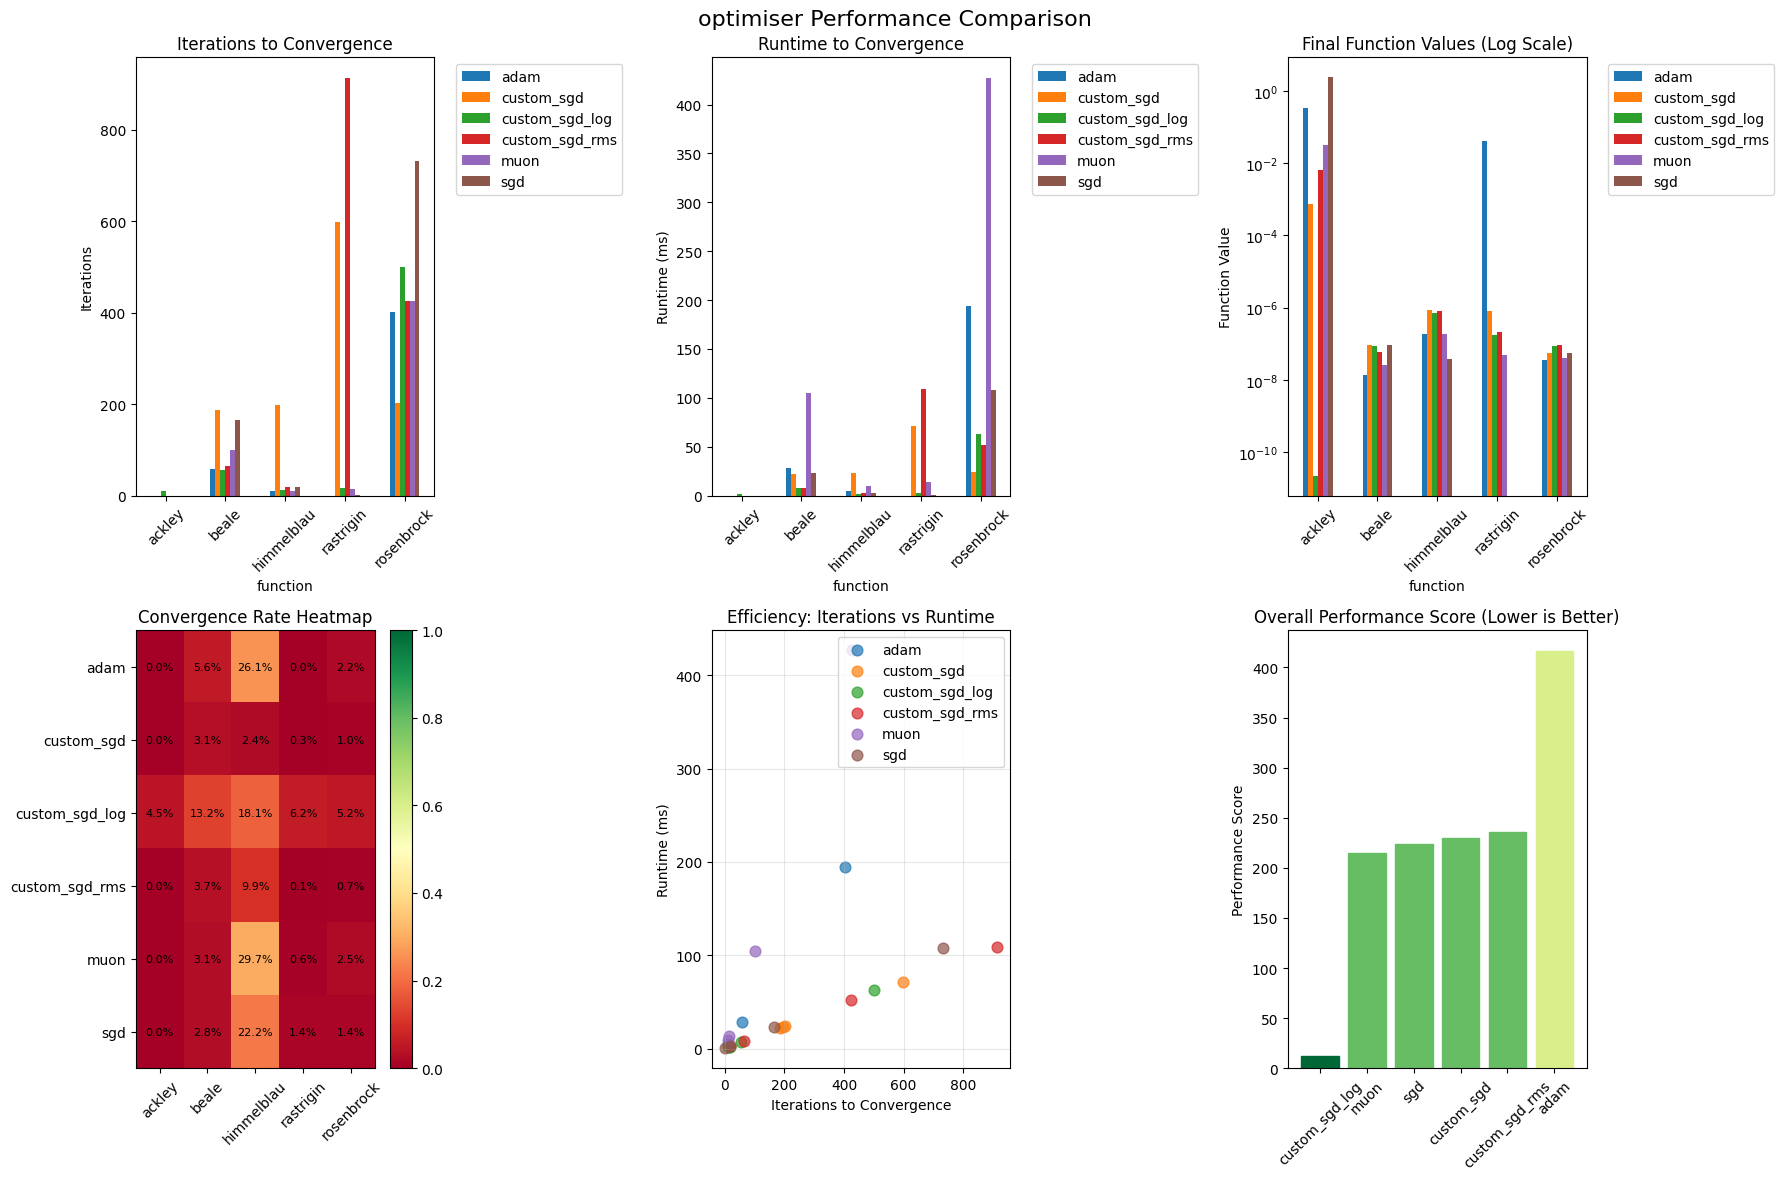

In [9]:
# Performance comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('optimiser Performance Comparison', fontsize=16)

# 1. Iterations to convergence (converged runs only)
ax = axes[0, 0]
converged_best = best_df[best_df['converged'] == True]
if len(converged_best) > 0:
    pivot_iterations = converged_best.pivot(index='function', columns='optimiser', values='iterations')
    pivot_iterations.plot(kind='bar', ax=ax, rot=45)
    ax.set_title('Iterations to Convergence')
    ax.set_ylabel('Iterations')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. Runtime comparison
ax = axes[0, 1]
converged_best = best_df[best_df['converged'] == True]
if len(converged_best) > 0:
    pivot_runtime = converged_best.pivot(index='function', columns='optimiser', values='runtime_ms')
    pivot_runtime.plot(kind='bar', ax=ax, rot=45)
    ax.set_title('Runtime to Convergence')
    ax.set_ylabel('Runtime (ms)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Final values (all runs)
ax = axes[0, 2]
pivot_values = best_df.pivot(index='function', columns='optimiser', values='final_value')
pivot_values.plot(kind='bar', ax=ax, rot=45, logy=True)
ax.set_title('Final Function Values (Log Scale)')
ax.set_ylabel('Function Value')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Convergence rate heatmap
ax = axes[1, 0]
convergence_matrix = df.groupby(['optimiser', 'function'])['converged'].mean().unstack()
im = ax.imshow(convergence_matrix.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax.set_xticks(range(len(convergence_matrix.columns)))
ax.set_xticklabels(convergence_matrix.columns, rotation=45)
ax.set_yticks(range(len(convergence_matrix.index)))
ax.set_yticklabels(convergence_matrix.index)
ax.set_title('Convergence Rate Heatmap')
plt.colorbar(im, ax=ax)

# Add text annotations
for i in range(len(convergence_matrix.index)):
    for j in range(len(convergence_matrix.columns)):
        text = ax.text(j, i, f'{convergence_matrix.iloc[i, j]:.1%}',
                      ha="center", va="center", color="black", fontsize=8)

# 5. Efficiency scatter plot (iterations vs runtime for converged runs)
ax = axes[1, 1]
for optimiser in converged_best['optimiser'].unique():
    opt_data = converged_best[converged_best['optimiser'] == optimiser]
    ax.scatter(opt_data['iterations'], opt_data['runtime_ms'], 
              label=optimiser, alpha=0.7, s=60)

ax.set_xlabel('Iterations to Convergence')
ax.set_ylabel('Runtime (ms)')
ax.set_title('Efficiency: Iterations vs Runtime')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Overall performance ranking
ax = axes[1, 2]
# Calculate performance score (lower is better)
performance_scores = []
for optimiser in best_df['optimiser'].unique():
    opt_data = best_df[best_df['optimiser'] == optimiser]
    converged_rate = opt_data['converged'].mean()
    avg_iterations = opt_data[opt_data['converged']]['iterations'].mean() if len(opt_data[opt_data['converged']]) > 0 else 1000
    avg_runtime = opt_data[opt_data['converged']]['runtime_ms'].mean() if len(opt_data[opt_data['converged']]) > 0 else 1000
    
    # Performance score combines convergence rate (higher is better) and speed (lower is better)
    score = (1 - converged_rate) * 1000 + avg_iterations * 0.1 + avg_runtime * 0.01
    performance_scores.append({'optimiser': optimiser, 'score': score, 'convergence_rate': converged_rate})

performance_df = pd.DataFrame(performance_scores).sort_values('score')
bars = ax.bar(performance_df['optimiser'], performance_df['score'])
ax.set_title('Overall Performance Score (Lower is Better)')
ax.set_ylabel('Performance Score')
ax.tick_params(axis='x', rotation=45)

# Color bars by convergence rate
colors = plt.cm.RdYlGn(performance_df['convergence_rate'])
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.tight_layout()
plt.show()

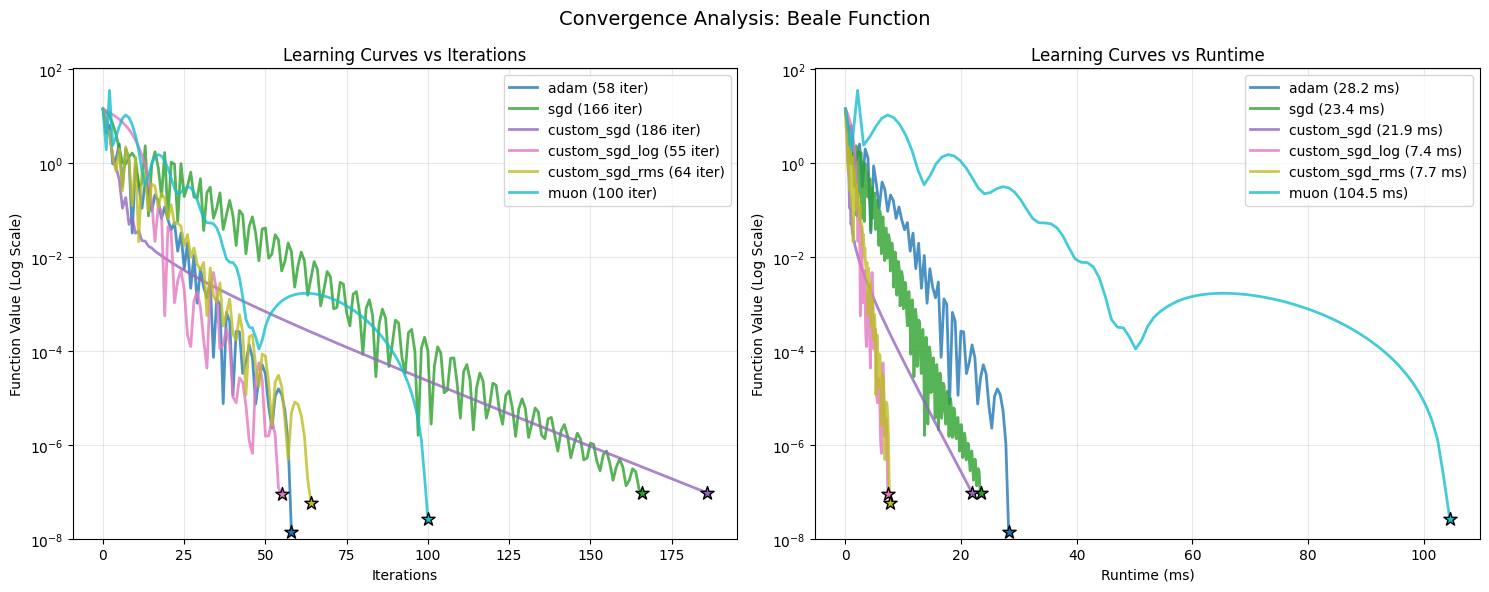


Beale Function Summary:
--------------------------------------------------
adam           : ✓ Converged  |   58 iter |   28.2 ms | Final: 1.40e-08
sgd            : ✓ Converged  |  166 iter |   23.4 ms | Final: 9.20e-08
custom_sgd     : ✓ Converged  |  186 iter |   21.9 ms | Final: 9.46e-08
custom_sgd_log : ✓ Converged  |   55 iter |    7.4 ms | Final: 8.88e-08
custom_sgd_rms : ✓ Converged  |   64 iter |    7.7 ms | Final: 5.91e-08
muon           : ✓ Converged  |  100 iter |  104.5 ms | Final: 2.64e-08


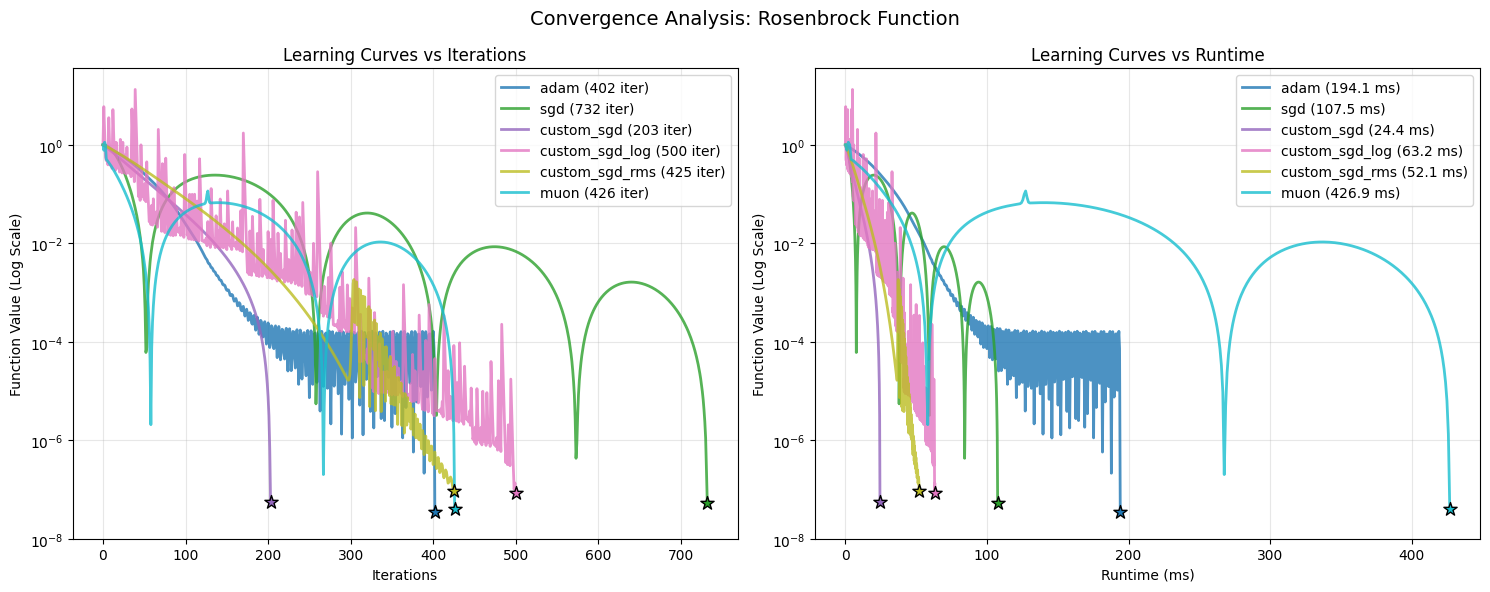


Rosenbrock Function Summary:
--------------------------------------------------
adam           : ✓ Converged  |  402 iter |  194.1 ms | Final: 3.44e-08
sgd            : ✓ Converged  |  732 iter |  107.5 ms | Final: 5.36e-08
custom_sgd     : ✓ Converged  |  203 iter |   24.4 ms | Final: 5.52e-08
custom_sgd_log : ✓ Converged  |  500 iter |   63.2 ms | Final: 8.42e-08
custom_sgd_rms : ✓ Converged  |  425 iter |   52.1 ms | Final: 9.32e-08
muon           : ✓ Converged  |  426 iter |  426.9 ms | Final: 3.94e-08


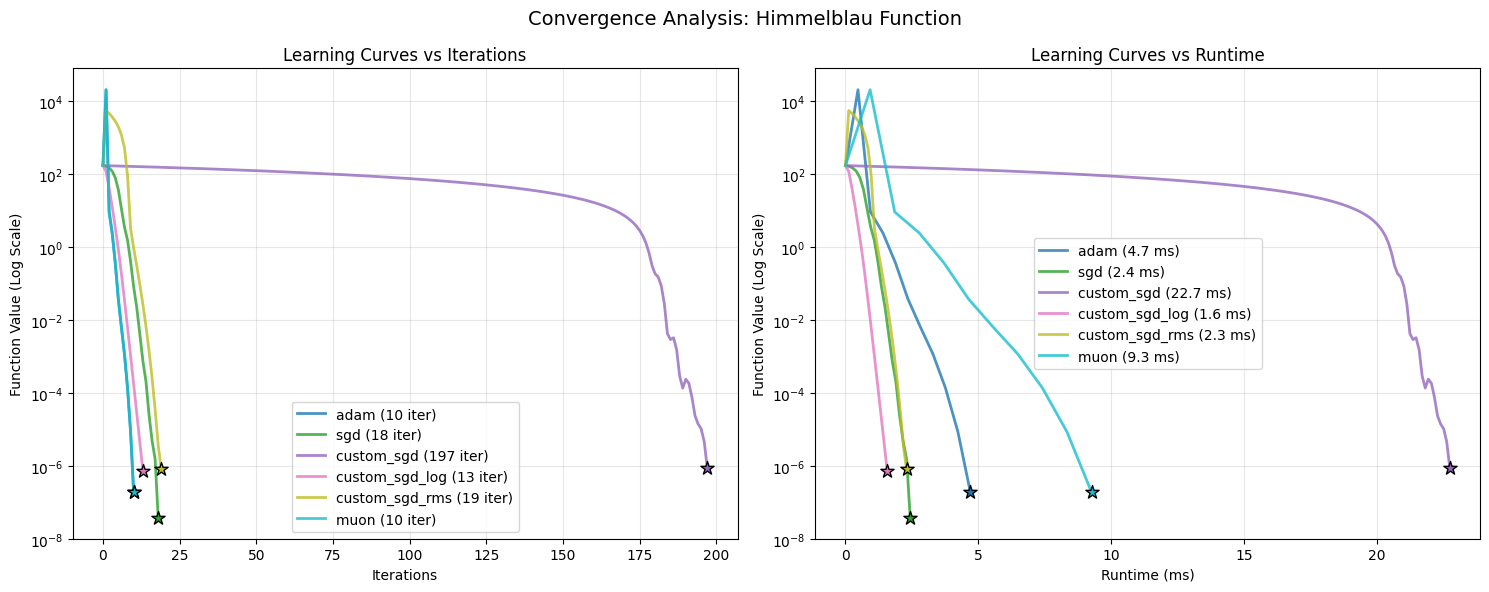


Himmelblau Function Summary:
--------------------------------------------------
adam           : ✓ Converged  |   10 iter |    4.7 ms | Final: 1.87e-07
sgd            : ✓ Converged  |   18 iter |    2.4 ms | Final: 3.69e-08
custom_sgd     : ✓ Converged  |  197 iter |   22.7 ms | Final: 8.71e-07
custom_sgd_log : ✓ Converged  |   13 iter |    1.6 ms | Final: 7.30e-07
custom_sgd_rms : ✓ Converged  |   19 iter |    2.3 ms | Final: 8.08e-07
muon           : ✓ Converged  |   10 iter |    9.3 ms | Final: 1.87e-07


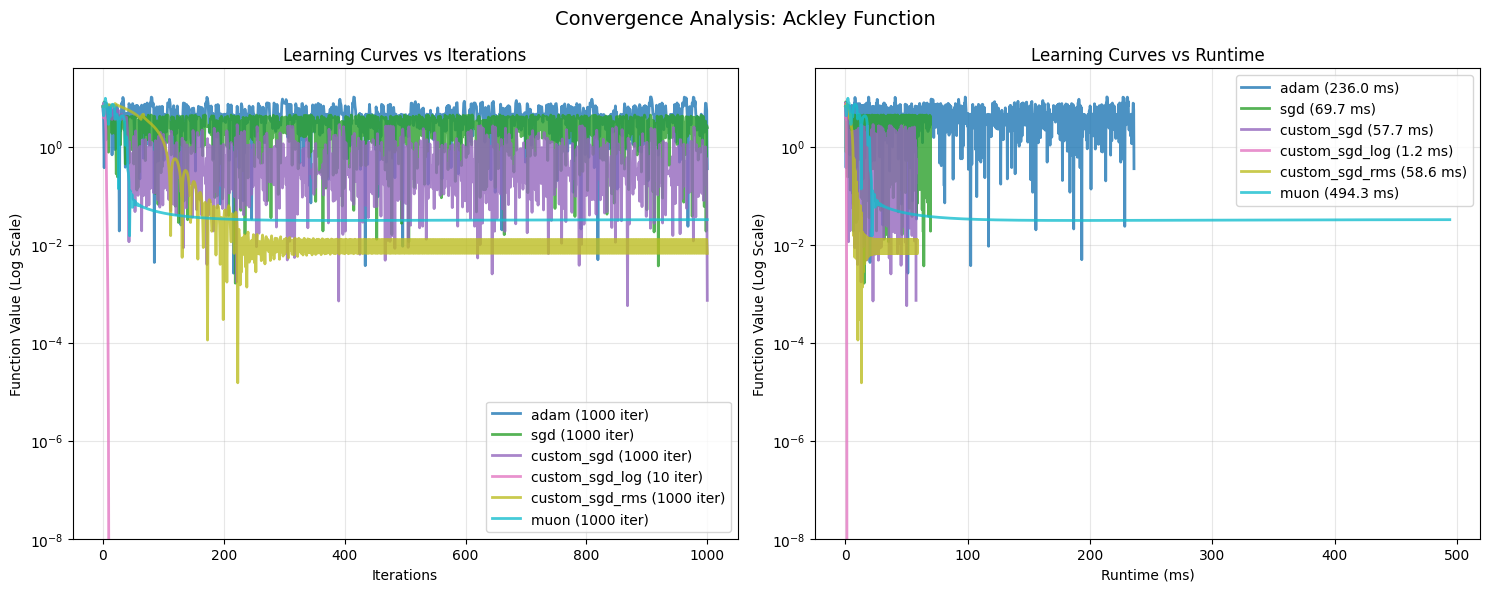


Ackley Function Summary:
--------------------------------------------------
adam           : ✗ Failed     | 1000 iter |  236.0 ms | Final: 3.54e-01
sgd            : ✗ Failed     | 1000 iter |   69.7 ms | Final: 2.44e+00
custom_sgd     : ✗ Failed     | 1000 iter |   57.7 ms | Final: 7.29e-04
custom_sgd_log : ✓ Converged  |   10 iter |    1.2 ms | Final: 2.20e-11
custom_sgd_rms : ✗ Failed     | 1000 iter |   58.6 ms | Final: 6.64e-03
muon           : ✗ Failed     | 1000 iter |  494.3 ms | Final: 3.23e-02


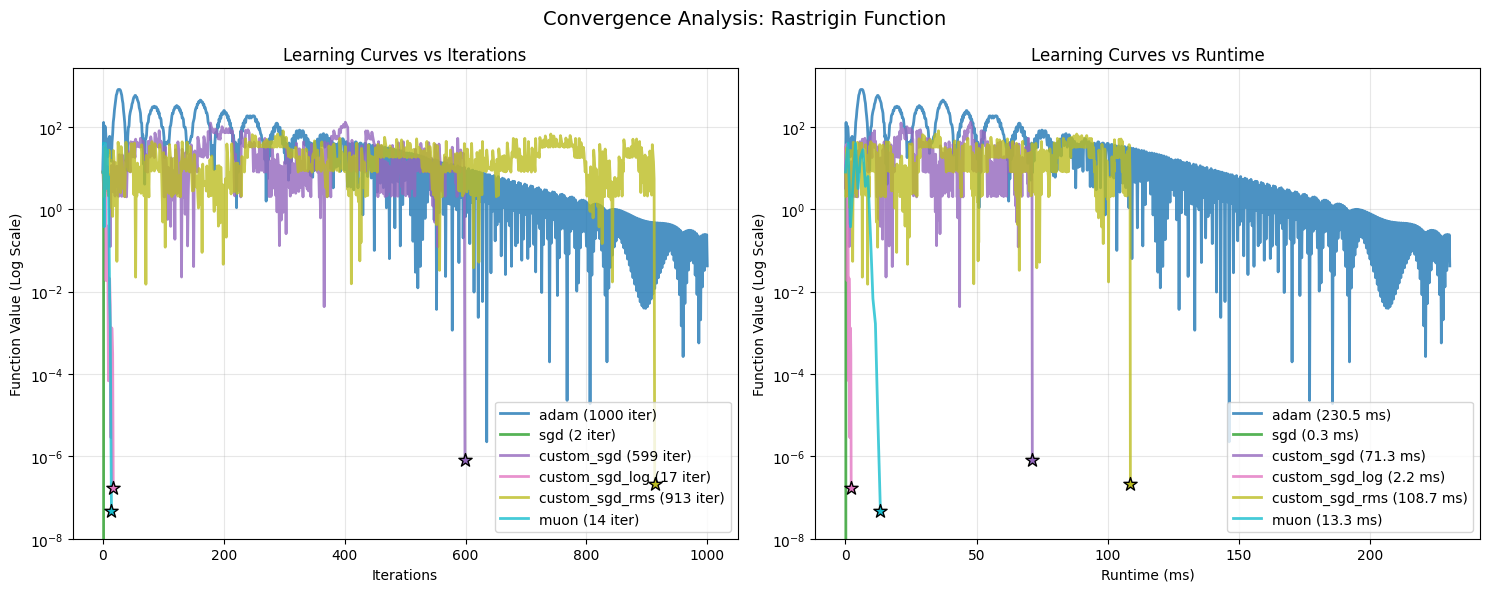


Rastrigin Function Summary:
--------------------------------------------------
adam           : ✗ Failed     | 1000 iter |  230.5 ms | Final: 4.21e-02
sgd            : ✓ Converged  |    2 iter |    0.3 ms | Final: 0.00e+00
custom_sgd     : ✓ Converged  |  599 iter |   71.3 ms | Final: 8.14e-07
custom_sgd_log : ✓ Converged  |   17 iter |    2.2 ms | Final: 1.74e-07
custom_sgd_rms : ✓ Converged  |  913 iter |  108.7 ms | Final: 2.16e-07
muon           : ✓ Converged  |   14 iter |   13.3 ms | Final: 4.78e-08


In [10]:
# Convergence analysis with learning curves
def plot_convergence_curves(results: List[OptimisationResult], function_name: str):
    """Plot convergence curves for all optimisers on a specific function"""
    
    # Get best result for each optimiser on this function
    function_results = [r for r in results if r.function_name == function_name]
    best_results_by_optimiser = {}
    
    for result in function_results:
        optimiser = result.optimiser_name
        if optimiser not in best_results_by_optimiser:
            best_results_by_optimiser[optimiser] = result
        else:
            # Compare results: prioritise converged, then by iterations/final value
            current_best = best_results_by_optimiser[optimiser]
            if (result.converged and not current_best.converged) or \
               (result.converged == current_best.converged and 
                (result.iterations < current_best.iterations if result.converged else 
                 result.final_value < current_best.final_value)):
                best_results_by_optimiser[optimiser] = result
    
    # Create only the first two plots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Convergence Analysis: {function_name.title()} Function', fontsize=14)
    
    colours = plt.cm.tab10(np.linspace(0, 1, len(best_results_by_optimiser)))
    
    # Plot 1: Learning curves vs iterations (log scale)
    ax1 = axes[0]
    for (optimiser, result), colour in zip(best_results_by_optimiser.items(), colours):
        history = result.convergence_history
        iterations = range(len(history))
        
        # Plot learning curve
        ax1.semilogy(iterations, history, label=f'{optimiser} ({result.iterations} iter)', 
                    color=colour, linewidth=2, alpha=0.8)
        
        # Mark convergence point if converged
        if result.converged:
            conv_iter = result.iterations
            conv_value = history[conv_iter]
            ax1.scatter(conv_iter, conv_value, color=colour, s=100, marker='*', 
                       edgecolor='black', linewidth=1, zorder=10)
    
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Function Value (Log Scale)')
    ax1.set_title('Learning Curves vs Iterations')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=1e-8)
    
    # Plot 2: Learning curves vs runtime (log scale)
    ax2 = axes[1]
    for (optimiser, result), colour in zip(best_results_by_optimiser.items(), colours):
        history = result.convergence_history
        # Create time axis based on total runtime
        time_points = np.linspace(0, result.runtime_seconds * 1000, len(history))
        
        # Plot learning curve vs time
        ax2.semilogy(time_points, history, label=f'{optimiser} ({result.runtime_seconds*1000:.1f} ms)', 
                    color=colour, linewidth=2, alpha=0.8)
        
        # Mark convergence point if converged
        if result.converged:
            conv_time = time_points[result.iterations]
            conv_value = history[result.iterations]
            ax2.scatter(conv_time, conv_value, color=colour, s=100, marker='*',
                       edgecolor='black', linewidth=1, zorder=10)
    
    ax2.set_xlabel('Runtime (ms)')
    ax2.set_ylabel('Function Value (Log Scale)')
    ax2.set_title('Learning Curves vs Runtime')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(bottom=1e-8)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{function_name.title()} Function Summary:")
    print("-" * 50)
    for optimiser, result in best_results_by_optimiser.items():
        status = "✓ Converged" if result.converged else "✗ Failed"
        print(f"{optimiser:15s}: {status:12s} | {result.iterations:4d} iter | "
              f"{result.runtime_seconds*1000:6.1f} ms | Final: {result.final_value:.2e}")

# Plot convergence curves for each function
for function_name in test_functions.keys():
    plot_convergence_curves(results, function_name)


In [11]:
#
print("=" * 80)
print("COMPREHENSIVE OPTIMISATION EXPERIMENT RESULTS")
print("=" * 80)

# Create summary table
summary_data = []
for function_name in test_functions.keys():
    function_results = [r for r in results if r.function_name == function_name]
    best_results_by_optimiser = {}
    
    for result in function_results:
        optimiser = result.optimiser_name
        if optimiser not in best_results_by_optimiser:
            best_results_by_optimiser[optimiser] = result
        else:
            current_best = best_results_by_optimiser[optimiser]
            if (result.converged and not current_best.converged) or \
               (result.converged == current_best.converged and 
                (result.iterations < current_best.iterations if result.converged else 
                 result.final_value < current_best.final_value)):
                best_results_by_optimiser[optimiser] = result
    
    for optimiser, result in best_results_by_optimiser.items():
        summary_data.append({
            'Function': function_name,
            'optimiser': optimiser,
            'Converged': result.converged,
            'Iterations': result.iterations,
            'Runtime (ms)': result.runtime_seconds * 1000,
            'Time per Iteration (ms)': (result.runtime_seconds * 1000) / result.iterations if result.iterations > 0 else 0,
            'Final Value': result.final_value,
            'Efficiency': result.iterations / (result.runtime_seconds * 1000) if result.runtime_seconds > 0 else 0
        })

summary_df = pd.DataFrame(summary_data)

# Display results by function
for function_name in test_functions.keys():
    print(f"\n{function_name.upper()} FUNCTION:")
    print("-" * 40)
    func_data = summary_df[summary_df['Function'] == function_name].sort_values('Iterations')
    for _, row in func_data.iterrows():
        status = "✓" if row['Converged'] else "✗"
        print(f"{status} {row['optimiser']:15s}: {row['Iterations']:4d} iter | "
              f"{row['Runtime (ms)']:6.1f} ms | {row['Final Value']:.2e}")

print(f"\n{'='*80}")
print("OVERALL RANKINGS:")
print("=" * 80)

# Overall performance ranking
print("\n1. BY CONVERGENCE RATE:")
convergence_ranking = summary_df.groupby('optimiser')['Converged'].mean().sort_values(ascending=False)
for i, (optimiser, rate) in enumerate(convergence_ranking.items(), 1):
    print(f"{i}. {optimiser:15s}: {rate:.1%}")

print("\n2. BY AVERAGE ITERATIONS (converged runs only):")
converged_df = summary_df[summary_df['Converged'] == True]
if len(converged_df) > 0:
    iteration_ranking = converged_df.groupby('optimiser')['Iterations'].mean().sort_values()
    for i, (optimiser, avg_iter) in enumerate(iteration_ranking.items(), 1):
        print(f"{i}. {optimiser:15s}: {avg_iter:.1f} iterations")

print("\n3. BY AVERAGE RUNTIME (converged runs only):")
if len(converged_df) > 0:
    runtime_ranking = converged_df.groupby('optimiser')['Runtime (ms)'].mean().sort_values()
    for i, (optimiser, avg_runtime) in enumerate(runtime_ranking.items(), 1):
        print(f"{i}. {optimiser:15s}: {avg_runtime:.1f} ms")

print("\n4. BY AVERAGE TIME PER ITERATION (converged runs only):")
if len(converged_df) > 0:
    time_per_iter_ranking = converged_df.groupby('optimiser')['Time per Iteration (ms)'].mean().sort_values()
    for i, (optimiser, avg_time_per_iter) in enumerate(time_per_iter_ranking.items(), 1):
        print(f"{i}. {optimiser:15s}: {avg_time_per_iter:.3f} ms/iter")

print(f"\n{'='*80}")
print("KEY INSIGHTS:")
print("=" * 80)

# Generate insights
total_experiments = len(summary_df)
total_converged = summary_df['Converged'].sum()
convergence_rate = total_converged / total_experiments

print(f"• Total experiments: {total_experiments}")
print(f"• Overall convergence rate: {convergence_rate:.1%}")
print(f"• Most reliable optimiser: {convergence_ranking.index[0]} ({convergence_ranking.iloc[0]:.1%} success)")

if len(converged_df) > 0:
    fastest_optimiser = iteration_ranking.index[0]
    fastest_iterations = iteration_ranking.iloc[0]
    print(f"• Fastest optimiser (iterations): {fastest_optimiser} ({fastest_iterations:.1f} avg)")
    
    quickest_optimiser = runtime_ranking.index[0]
    quickest_runtime = runtime_ranking.iloc[0]
    print(f"• Quickest optimiser (runtime): {quickest_optimiser} ({quickest_runtime:.1f} ms avg)")
    
    most_efficient_optimiser = time_per_iter_ranking.index[0]
    most_efficient_time = time_per_iter_ranking.iloc[0]
    print(f"• Most efficient optimiser (time/iter): {most_efficient_optimiser} ({most_efficient_time:.3f} ms/iter avg)")

# Function difficulty ranking
function_difficulty = summary_df.groupby('Function')['Converged'].mean().sort_values()
print(f"• Most challenging function: {function_difficulty.index[0]} ({function_difficulty.iloc[0]:.1%} success)")
print(f"• Easiest function: {function_difficulty.index[-1]} ({function_difficulty.iloc[-1]:.1%} success)")

print(f"\n{'='*80}")

COMPREHENSIVE OPTIMISATION EXPERIMENT RESULTS

BEALE FUNCTION:
----------------------------------------
✓ custom_sgd_log :   55 iter |    7.4 ms | 8.88e-08
✓ adam           :   58 iter |   28.2 ms | 1.40e-08
✓ custom_sgd_rms :   64 iter |    7.7 ms | 5.91e-08
✓ muon           :  100 iter |  104.5 ms | 2.64e-08
✓ sgd            :  166 iter |   23.4 ms | 9.20e-08
✓ custom_sgd     :  186 iter |   21.9 ms | 9.46e-08

ROSENBROCK FUNCTION:
----------------------------------------
✓ custom_sgd     :  203 iter |   24.4 ms | 5.52e-08
✓ adam           :  402 iter |  194.1 ms | 3.44e-08
✓ custom_sgd_rms :  425 iter |   52.1 ms | 9.32e-08
✓ muon           :  426 iter |  426.9 ms | 3.94e-08
✓ custom_sgd_log :  500 iter |   63.2 ms | 8.42e-08
✓ sgd            :  732 iter |  107.5 ms | 5.36e-08

HIMMELBLAU FUNCTION:
----------------------------------------
✓ adam           :   10 iter |    4.7 ms | 1.87e-07
✓ muon           :   10 iter |    9.3 ms | 1.87e-07
✓ custom_sgd_log :   13 iter |    1.6 ms |

In [12]:
# Print hyperparameters for the best runs
print("=" * 80)
print("BEST HYPERPARAMETERS FOR EACH OPTIMIZER-FUNCTION COMBINATION")
print("=" * 80)

# Get best results with hyperparameters
best_results_with_config = []
for function_name in test_functions.keys():
    function_results = [r for r in results if r.function_name == function_name]
    
    for optimiser_name in set(r.optimiser_name for r in function_results):
        optimiser_results = [r for r in function_results if r.optimiser_name == optimiser_name]
        
        # Find best result for this optimiser-function combination
        best_result = None
        for result in optimiser_results:
            if best_result is None:
                best_result = result
            else:
                # Prioritize converged runs, then by iterations/final value
                if (result.converged and not best_result.converged) or \
                   (result.converged == best_result.converged and 
                    (result.iterations < best_result.iterations if result.converged else 
                     result.final_value < best_result.final_value)):
                    best_result = result
        
        if best_result:
            best_results_with_config.append({
                'function': function_name,
                'optimiser': optimiser_name,
                'converged': best_result.converged,
                'iterations': best_result.iterations,
                'final_value': best_result.final_value,
                'runtime_ms': best_result.runtime_seconds * 1000,
                'config': best_result.config
            })

# Display by function
for function_name in test_functions.keys():
    print(f"\n{function_name.upper()} FUNCTION:")
    print("-" * 50)
    
    function_data = [r for r in best_results_with_config if r['function'] == function_name]
    function_data.sort(key=lambda x: (not x['converged'], x['iterations'] if x['converged'] else x['final_value']))
    
    for result in function_data:
        status = "✓" if result['converged'] else "✗"
        print(f"{status} {result['optimiser']:18s} | {result['iterations']:4d} iter | {result['final_value']:.2e}")
        
        # Parse and display config nicely
        config = result['config']
        if isinstance(config, str):
            # Remove quotes and braces, split by comma
            config_clean = config.strip("'{}")
            config_pairs = [pair.strip() for pair in config_clean.split(',') if pair.strip()]
            config_str = " | ".join(config_pairs)
        else:
            # If config is already a dict
            config_str = " | ".join([f"{k}: {v}" for k, v in config.items()])
        
        print(f"  └─ {config_str}")
        print()

print("=" * 80)
print("SUMMARY: BEST HYPERPARAMETERS BY OPTIMIZER")
print("=" * 80)

# Group by optimizer and find most common hyperparameters
for optimiser_name in set(r['optimiser'] for r in best_results_with_config):
    print(f"\n{optimiser_name.upper()}:")
    print("-" * 30)
    
    optimiser_data = [r for r in best_results_with_config if r['optimiser'] == optimiser_name]
    converged_data = [r for r in optimiser_data if r['converged']]
    
    print(f"Success rate: {len(converged_data)}/{len(optimiser_data)} ({len(converged_data)/len(optimiser_data):.1%})")
    
    if converged_data:
        # Find the configuration that appears most often among successful runs
        configs = [r['config'] for r in converged_data]
        
        # Extract common parameter patterns
        all_params = {}
        for config in configs:
            if isinstance(config, str):
                # Parse string config
                config_clean = config.strip("'{}")
                for pair in config_clean.split(','):
                    if ':' in pair:
                        key, value = pair.split(':', 1)
                        key = key.strip().strip("'\"")
                        value = value.strip().strip("'\"")
                        if key not in all_params:
                            all_params[key] = []
                        all_params[key].append(value)
            else:
                # Handle dict config
                for key, value in config.items():
                    if key not in all_params:
                        all_params[key] = []
                    all_params[key].append(str(value))
        
        # Find most common values for each parameter
        print("Most successful parameter ranges:")
        for param, values in all_params.items():
            # Count unique values
            value_counts = {}
            for val in values:
                value_counts[val] = value_counts.get(val, 0) + 1
            
            # Sort by frequency
            sorted_values = sorted(value_counts.items(), key=lambda x: x[1], reverse=True)
            
            if len(sorted_values) == 1:
                print(f"  {param}: {sorted_values[0][0]} (always)")
            else:
                top_values = [f"{val} ({count}x)" for val, count in sorted_values[:3]]
                print(f"  {param}: {', '.join(top_values)}")
    
    print()

BEST HYPERPARAMETERS FOR EACH OPTIMIZER-FUNCTION COMBINATION

BEALE FUNCTION:
--------------------------------------------------
✓ custom_sgd_log     |   55 iter | 8.88e-08
  └─ learning_rate: 0.1 | momentum: 0.5 | xi: 0.01 | beta: 0.0

✓ adam               |   58 iter | 1.40e-08
  └─ learning_rate: 1 | b1: 0.75 | b2: 0.99 | eps: 1e-08

✓ custom_sgd_rms     |   64 iter | 5.91e-08
  └─ learning_rate: 1 | momentum: 0.75 | xi: 0.01 | beta: 0.0 | beta_rms: 0.999 | eps: 1e-08

✓ muon               |  100 iter | 2.64e-08
  └─ learning_rate: 1 | adam_b1: 0.9 | adam_b2: 0.99 | eps: 1e-08 | beta: 0.9

✓ sgd                |  166 iter | 9.20e-08
  └─ learning_rate: 0.01 | momentum: 0.9

✓ custom_sgd         |  186 iter | 9.46e-08
  └─ learning_rate: 0.1 | momentum: 0.5 | xi: 0.01 | beta: 0.0


ROSENBROCK FUNCTION:
--------------------------------------------------
✓ custom_sgd         |  203 iter | 5.52e-08
  └─ learning_rate: 0.01 | momentum: 0.99 | xi: 0.1 | beta: 0.0

✓ adam               |  